In [26]:
# load prepared data
import pandas as pd
r = pd.read_csv('result.csv', encoding='utf8')
r = r[r['Answer']!='not']
len(r)

2527

In [27]:
# import libs
from tokenize_uk import *
import os,sys
mitie_path = os.environ['MITIE_HOME']
sys.path.append(mitie_path)

from mitie import *
import itertools
import re

In [28]:
# load previous models
ner = named_entity_extractor("uk_model.dat")
trainer = binary_relation_detector_trainer("people.person.parents", ner)

In [29]:
# tokenize texts and find anchors
def detect_anchor(tokens, anchor):
    found = False
    index = 0
    for i in range(len(tokens)):
        token = tokens[i]
        pattern = re.escape(anchor[index]) + u"[а|ом]?"
        match = re.match(pattern, token, flags=re.U|re.L)
        
        if(found):
            if(match is not None):
                index += 1
            else:
                index = 0
                found = False
                pattern = re.escape(anchor[index]) + u"[а|ом]?"
                match = re.match(pattern, token, flags=re.U|re.L)
        
        if(not found and match is not None):
            start = i
            index += 1
            found = True
            
        if(index == len(anchor)):
            end = i + 1
            yield range(start, end)
            index = 0
            found = False
            
def extract_from_tokens_by_range(tokens, r):
    return ' '.join(tokens[r[0]:r[-1]+1])

def convert_answer(answer):
    if(answer=='has' or answer=='weak'):
        return 1
    else:
        return 0
    
def convert_predicate(p):
    if(p=='P22'):
        return 1
    else:
        return 0
    
def prepare_row(row, verbose=False):
    text = row['Text']
    if(verbose):
        print text
    tokens = tokenize_text(text)
    tokens = [t for tt in tokens for sentence in tt for t in sentence]
    detection1 = list(detect_anchor(tokens, tokenize_words(row['SubjectAnchor'])))
    if(verbose):
        for d in detection1:
            print extract_from_tokens_by_range(tokens, d)
    detection2 = list(detect_anchor(tokens, tokenize_words(row['ObjectAnchor'])))
    if(verbose):
        for d in detection2:
            print extract_from_tokens_by_range(tokens, d)
            
    return (tokens, detection1, detection2, convert_answer(row['Answer']), convert_predicate(row['PredicateId']))

df = pd.DataFrame(list(r.apply(prepare_row,axis=1)), columns=['Text','Subjects','Objects','Answer', 'Predicate'])
df.head()

,Text,Subjects,Objects,Answer,Predicate
0,"[Кім, Чен, Ин, (, нар, ., 1983, ), —, син, кол...","[[0, 1, 2]]","[[13, 14, 15]]",1,1
1,"[При, ЧандрагуптіІ, ,, внукові, Шрі, -, Гупти,...","[[27, 28]]",[[25]],1,1
2,"[Походив, із, середніх, італійських, прошарків...","[[16, 17, 18]]","[[7, 8, 9]]",0,1
3,"[Відомо, ,, що, працював, за, імператорів, Шун...","[[10, 11, 12]]","[[6, 7, 8]]",1,1
4,"[Коли, ж, ,, наступного, року, ,, його, здоров...","[[36, 37]]","[[11, 12]]",1,1


In [30]:
# remove invalid values
correct = df.apply(lambda row: len(row['Subjects']) > 0 and len(row['Objects']) > 0, axis=1)
df = df[correct]

In [31]:
# flatten subjects and objects to one value per row
def unstack_column(df, col):
    indicies = df.index
    for i in indicies:
        row = df.loc[i]
        val = row[col]
        while(len(val) > 1):
            v = val.pop(1)
            row[col] = v
            df.loc[df.index.max() + 1] = list(row)
            #print v
        
        #print val[0] 
        df.set_value(i, col, val[0])
        
        
unstack_column(df, 'Subjects')
unstack_column(df, 'Objects')
df.head(5)

C:\Users\Anatoliy\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Text,Subjects,Objects,Answer,Predicate
0,"[Кім, Чен, Ин, (, нар, ., 1983, ), —, син, кол...","[0, 1, 2]","[13, 14, 15]",1,1
1,"[При, ЧандрагуптіІ, ,, внукові, Шрі, -, Гупти,...","[27, 28]",[25],1,1
2,"[Походив, із, середніх, італійських, прошарків...","[16, 17, 18]","[7, 8, 9]",0,1
3,"[Відомо, ,, що, працював, за, імператорів, Шун...","[10, 11, 12]","[6, 7, 8]",1,1
4,"[Коли, ж, ,, наступного, року, ,, його, здоров...","[36, 37]","[11, 12]",1,1


In [32]:
# remove entries with overlapping entities
def no_range_overlaps(r1, r2):
    return max(r1) < min(r2) or max(r2) < min(r1)

no_overlap = df.apply(lambda row: no_range_overlaps(row['Subjects'], row['Objects']), axis=1)
df = df[no_overlap]

In [57]:
len(df)

2925

In [33]:
# get test split
from sklearn.model_selection import StratifiedKFold

X = df[['Predicate']]
y = df['Answer']

state = 42
test_split = StratifiedKFold(n_splits=4, shuffle=True, random_state=state).split(X, y).next() # golden set
test_i = test_split[1]
train_i = test_split[0]

In [34]:
# mitie trainig function
def train_mitie_model(X, y, train_index):
    for i in train_index:
        
        subject_position = X.iloc[i]['Subjects']
        object_position = X.iloc[i]['Objects']
        text = X.iloc[i]['Text']

        if(y.iloc[i]==1):
            trainer.add_positive_binary_relation(text, subject_position, object_position)
            trainer.add_negative_binary_relation(text, object_position, subject_position)
        else:
            trainer.add_negative_binary_relation(text, subject_position, object_position)
    return trainer.train()

mitie_model = train_mitie_model(df, df['Answer'], train_i)

In [35]:
# logistic regression trainig function
from sklearn.linear_model import LogisticRegression
import numpy as np

def mitie_predict(model, text, subj, obj):
    rel = ner.extract_binary_relation(text, subj, obj)
    return model(rel)

def train_logreg_model(mitie_model, X, y, train_index):
    logreg_x = X.iloc[train_index].apply(lambda row: mitie_predict(mitie_model, row['Text'], row['Subjects'], row['Objects']), axis=1)
    model = LogisticRegression(random_state=state)
    logreg_x = np.array(logreg_x).reshape((len(logreg_x), 1))
    logreg_y = np.array(y.iloc[train_index])
    model.fit(logreg_x, logreg_y)
    return model

logreg_model = train_logreg_model(mitie_model, df, y, train_i)
logreg_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
# testing
from sklearn.metrics import average_precision_score, recall_score, f1_score, precision_score

logreg_x = df.iloc[test_i].apply(lambda row: mitie_predict(mitie_model, row['Text'], row['Subjects'], row['Objects']), axis=1)
logreg_x = np.array(logreg_x).reshape((len(logreg_x), 1))
y_pred_proba = logreg_model.predict_proba(logreg_x)[:,1]
y_pred = logreg_model.predict(logreg_x)
y_true = np.array(y.iloc[test_i].astype(float))

print "PR AUC: " + str(average_precision_score(y_true, y_pred_proba))
print "Recall: " + str(recall_score(y_true, y_pred))
print "Precision: " + str(precision_score(y_true, y_pred))
print "F1: " + str(f1_score(y_true, y_pred))

PR AUC: 0.629195941433
Recall: 0.665127020785
Precision: 0.606315789474
F1: 0.63436123348


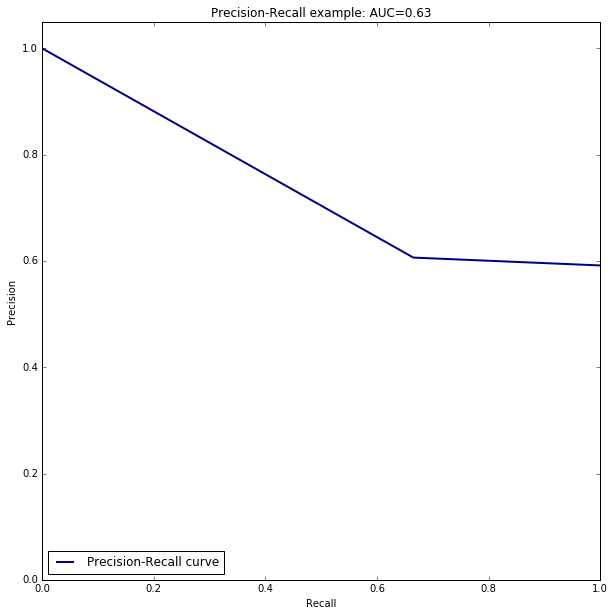

In [49]:
# plot PR curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)
from itertools import cycle

precision, recall, _ = precision_recall_curve(y_true, y_pred)

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision_score(y_true, y_pred_proba)))
plt.legend(loc="lower left")
plt.show()

In [38]:
mitie_model.save_to_disk("people.person.parents.svm")

In [56]:
threshold = 0.2
y_pred_t = map(lambda y: 1.0 if y > threshold else 0.0, y_pred_proba)


print "PR AUC: " + str(average_precision_score(y_true, y_pred_proba))
print "Recall: " + str(recall_score(y_true, y_pred_t))
print "Precision: " + str(precision_score(y_true, y_pred_t))
print "F1: " + str(f1_score(y_true, y_pred_t))

PR AUC: 0.629195941433
Recall: 0.829099307159
Precision: 0.604377104377
F1: 0.699123661149
